## 1D simulation

### Simulation Setup

The following is a 1D simulation including cosmic evolution. 
The sources are modeled to be uniformly distributed and emit a mixed composition of H, He, N and Fe with a power-law spectrum and a charge dependent maximum energy.

To include cosmological effects in this 1D simulation we need two things:

First, the ```Redshift``` module updates the current redshift of the particle in each propagation step. It is best added directly after the propagation module, although the postion shouldn't matter much for the typically small propagation steps.

Second, we need to set the initial redshift of the particles.
In 1D simulations the intial redshift is determined by the source distance. To have the source automatically set the redshift we add ```SourceRedshift1D```. **Please note** that it has to be added after the source property that defines the source position.

**Note: The simulation might take a few minutes**

In [1]:
from crpropa import *

# simulation setup
sim = ModuleList()
sim.add( SimplePropagation(1*kpc, 10*Mpc) )
sim.add( Redshift() )
sim.add( PhotoPionProduction(CMB) )
sim.add( PhotoPionProduction(IRB) )
sim.add( PhotoDisintegration(CMB) )
sim.add( PhotoDisintegration(IRB) )
sim.add( NuclearDecay() )
sim.add( ElectronPairProduction(CMB) )
sim.add( ElectronPairProduction(IRB) )
sim.add( MinimumEnergy( 1 * EeV) )

# observer and output
obs = Observer()
obs.add( ObserverPoint() )
output = TextOutput('events.txt', Output.Event1D)
obs.onDetection( output )
sim.add( obs )

# source
source = Source()
source.add( SourceUniform1D(1 * Mpc, 1000 * Mpc) )
source.add( SourceRedshift1D() )

# power law spectrum with charge dependent maximum energy Z*100 EeV
# elements: H, He, N, Fe with equal abundances at constant energy per nucleon
composition = SourceComposition(1 * EeV, 100 * EeV, -1)
composition.add(1,  1,  1)  # H
composition.add(4,  2,  1)  # He-4
composition.add(14, 7,  1)  # N-14
composition.add(56, 26, 1)  # Fe-56
source.add( composition )

# run simulation
sim.setShowProgress(True)
sim.run(source, 20000, True)

### (Optional) Plotting

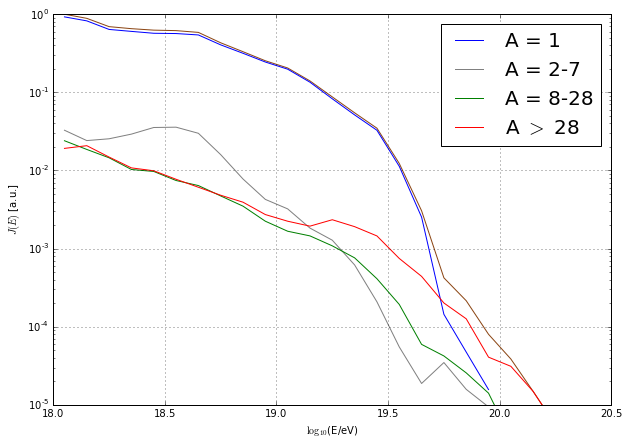

In [2]:
%matplotlib inline
import pylab as pl
# load events
output.close()
d = pl.genfromtxt('events.txt', names=True)

# observed quantities
Z = pl.array([chargeNumber(id) for id in d['ID'].astype(int)])  # element
A = pl.array([massNumber(id) for id in d['ID'].astype(int)])  # atomic mass number
lE = pl.log10(d['E']) + 18  # energy in log10(E/eV))

lEbins = pl.arange(18, 20.51, 0.1)  # logarithmic bins
lEcens = (lEbins[1:] + lEbins[:-1]) / 2  # logarithmic bin centers
dE = 10**lEbins[1:] - 10**lEbins[:-1]  # bin widths

# identify mass groups
idx1 = A == 1
idx2 = (A > 1) * (A <= 7)
idx3 = (A > 7) * (A <= 28)
idx4 = (A > 28)

# calculate spectrum: J(E) = dN/dE 
J  = pl.histogram(lE, bins=lEbins)[0] / dE
J1 = pl.histogram(lE[idx1], bins=lEbins)[0] / dE
J2 = pl.histogram(lE[idx2], bins=lEbins)[0] / dE
J3 = pl.histogram(lE[idx3], bins=lEbins)[0] / dE
J4 = pl.histogram(lE[idx4], bins=lEbins)[0] / dE

# normalize
J1 /= J[0]
J2 /= J[0]
J3 /= J[0] 
J4 /= J[0]
J /= J[0]

pl.figure(figsize=(10,7))
pl.plot(lEcens, J,  color='SaddleBrown')
pl.plot(lEcens, J1, color='blue', label='A = 1')
pl.plot(lEcens, J2, color='grey', label='A = 2-7')
pl.plot(lEcens, J3, color='green', label='A = 8-28')
pl.plot(lEcens, J4, color='red', label='A $>$ 28')
pl.legend(fontsize=20, frameon=True)
pl.semilogy()
pl.ylim(1e-5)
pl.grid()
pl.ylabel('$J(E)$ [a.u.]')
pl.xlabel('$\log_{10}$(E/eV)')
pl.savefig('sim1D_spectrum.png')